This tool tries to segment bursts of sound from otherwise quiet recordings in `data/project/raw`. It starts by thresholding the amplitude of the audio over time, and then removes very short sounds, and combines two sounds with a short silence into one.

In [1]:
data_root = '/home/tracek/Data/Birdman/'
plot = True
save = True
threshold_amp = 0.1
min_duration = 0.050
max_duration = 0.750
max_samples = None # set to "None" to save all the samples
sr = 44100
n_fft = 2048
hop_length = n_fft//4
limit = None

In [2]:
%matplotlib inline
from scipy.stats.mstats import mode
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.signal import argrelmin, argrelmax
from scipy.ndimage.filters import gaussian_filter1d as gaussian
from scipy.stats.mstats import mode
from utils.list_all_files import list_all_files
from utils.ffmpeg_load_audio import ffmpeg_load_audio
from utils.ffmpeg_save_audio import ffmpeg_save_audio
from IPython.display import display, Audio
from random import shuffle
import pickle as pickle
import os
import glob
from os.path import join
import librosa
import librosa.display
import numpy as np

In [3]:
files = glob.glob(data_root + 'raw/*.wav')

In [4]:
files

['/home/tracek/Data/Birdman/raw/STHELENA-02_20140520_200000_1.wav']

In [5]:
def split_chunks(x):
    chunks = []
    previous = None
    for sample in x:
        if sample != previous:
            chunks.append([])
        chunks[-1].append(sample)
        previous = sample
    return chunks

def join_chunks(chunks):
    return [item for sublist in chunks for item in sublist]

def replace_small_chunks(chunks, search, substitute, min_length):
    modified = []
    for chunk in chunks:
        cur = chunk[0]
        if cur == search and len(chunk) < min_length:
            cur = substitute
        modified.append([cur for x in chunk])
    return split_chunks(join_chunks(modified))

# do a grid search to determine the min and max chunk sizes
# that minimize standard deviation of chunk lengths
def get_optimal_chunks(chunks, min_length=3, max_length=500, n=10):
    best_std = None
    best_chunks = []
    for quiet_thresh in np.linspace(min_length, max_length, n):
        for sound_thresh in np.linspace(min_length, max_length, n):
            cur = replace_small_chunks(chunks, False, True, quiet_thresh)
            cur = replace_small_chunks(cur, True, False, sound_thresh)
            chunk_lengths = [len(chunk) for chunk in cur]
            cur_std = np.std(chunk_lengths)
            if (best_std is None or cur_std < best_std) and len(cur) > 1:
#                 print cur_std, 'better than', best_std, 'using', quiet_thresh, sound_thresh
                best_chunks = cur
                best_std = cur_std
    return best_chunks

STHELENA-02_20140520_200000_1 566 seconds


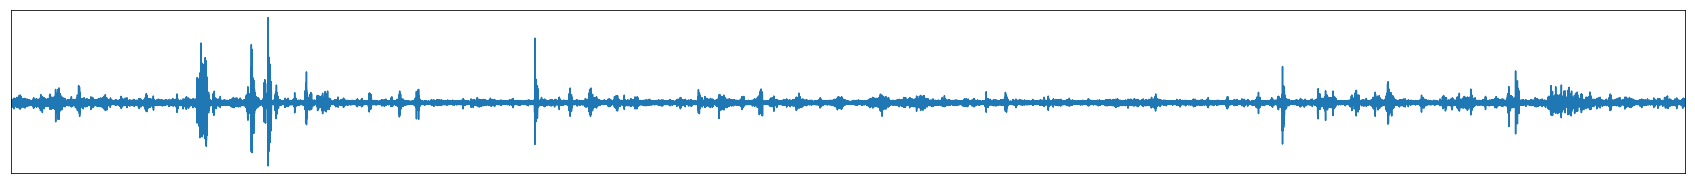

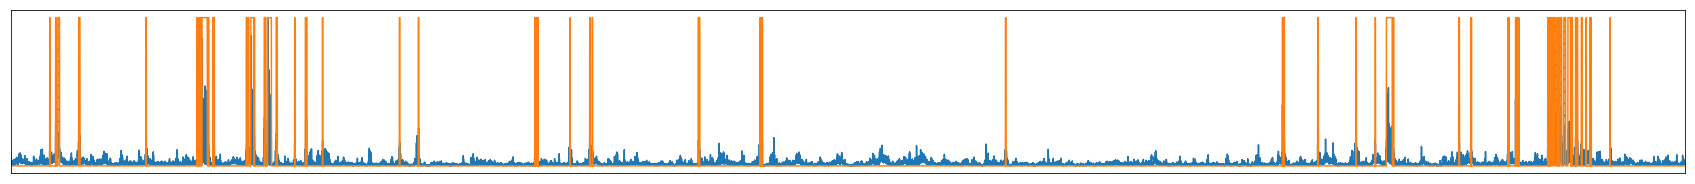

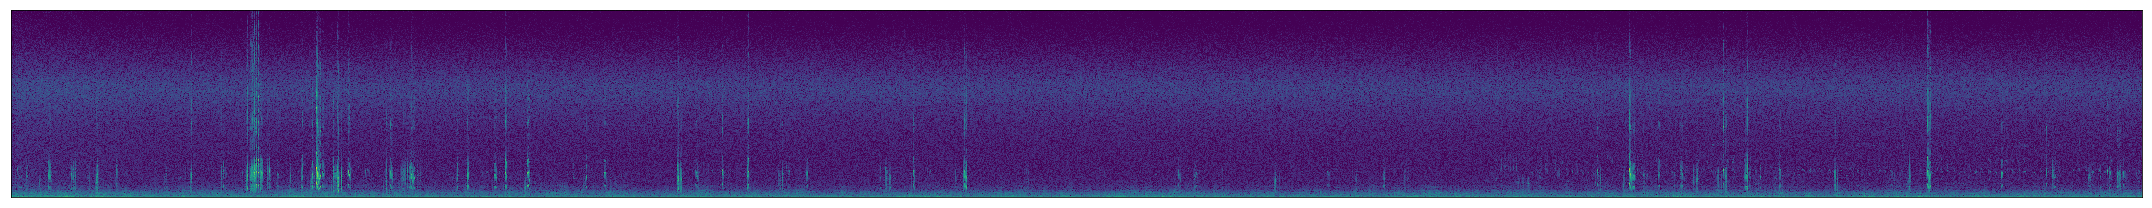

In [6]:
min_duration_frames = librosa.core.time_to_frames([min_duration], sr=sr, hop_length=hop_length)[0]
max_duration_frames = librosa.core.time_to_frames([max_duration], sr=sr, hop_length=hop_length)[0]
plot_downsample = 100
figsize = (30,3)
i = 0
for fn in files[:limit]:
    basename = os.path.basename(fn).split('.')[0]    
    y, _ = ffmpeg_load_audio(fn, sr=sr)
    y = y[0,:] # take one channel, avoid mid/side and out-of-phase errors
    y /= y.max()
    
    print(basename, int(len(y)/sr), 'seconds')
    
    if plot:
        # plot the raw waveform
        plt.figure(figsize=figsize)
        plt.plot(y[::plot_downsample])
        plt.xlim([0, len(y)/plot_downsample])
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        plt.show()
    
    # compute the rmse and threshold at a fixed value
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    e = librosa.feature.rmse(S=S)[0]
    e -= e.min()
    e /= e.max()
    et = np.where(e < threshold_amp, False, True)
    
    # split the thresholded audio into chunks and combine them optimally
    chunks = split_chunks(et)
    chunks = get_optimal_chunks(chunks, min_duration_frames, max_duration_frames, 10)
    et = join_chunks(chunks)
    
    if plot:
        # plot the rmse and thresholded rmse
        plt.figure(figsize=figsize)
        plt.plot(e)
        plt.plot(et)

    # convert chunks into "slices": beginning and end position pairs
    slices = []
    cur_slice = 0
    for chunk in chunks:
        next_slice = cur_slice + len(chunk)
        if chunk[0] and len(chunk) < max_duration_frames:
            slices.append([cur_slice, next_slice])
        cur_slice = next_slice
        
    for left, right in slices[:max_samples]:
        if plot:
            # highlight saved chunks
            plt.gca().add_patch(patches.Rectangle((left, 0), (right - left), 1,
                                                 hatch='//', alpha=0.2, fill='black'))

        if save:
            sample = np.copy(y[left*hop_length:right*hop_length])
            sample /= np.abs(sample).max()
            ffmpeg_save_audio(join(data_root, 'samples_kyle/{} {}.wav'.format(i, basename)), sample, sr=sr)
            i += 1
    
    if plot:
        # finish up the plot we've been building
        plt.xlim([0, len(e)])
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        plt.show()

        # plot the log amplitude spectrogram
        plt.figure(figsize=figsize)
        logamp = librosa.logamplitude(S**2, ref_power=np.max)
        librosa.display.specshow(logamp, sr=sr, cmap='viridis')
        plt.tight_layout()
        plt.show()

In [7]:
max_duration_frames

64

In [8]:
len(y)

25000000

In [9]:
n_fft

2048

In [10]:
hop_length

512